# Лекция 4

In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [4]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [5]:
series = pd.read_csv('international-airline-passengers.csv').dropna().values[:, 1]
print(series)

[112 118 132 129 121 135 148 148 136 119 104 118 115 126 141 135 125 149
 170 170 158 133 114 140 145 150 178 163 172 178 199 199 184 162 146 166
 171 180 193 181 183 218 230 242 209 191 172 194 196 196 236 235 229 243
 264 272 237 211 180 201 204 188 235 227 234 264 302 293 259 229 203 229
 242 233 267 269 270 315 364 347 312 274 237 278 284 277 317 313 318 374
 413 405 355 306 271 306 315 301 356 348 355 422 465 467 404 347 305 336
 340 318 362 348 363 435 491 505 404 359 310 337 360 342 406 396 420 472
 548 559 463 407 362 405 417 391 419 461 472 535 622 606 508 461 390 432]


Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


/Users/lu/opt/anaconda3/envs/old/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


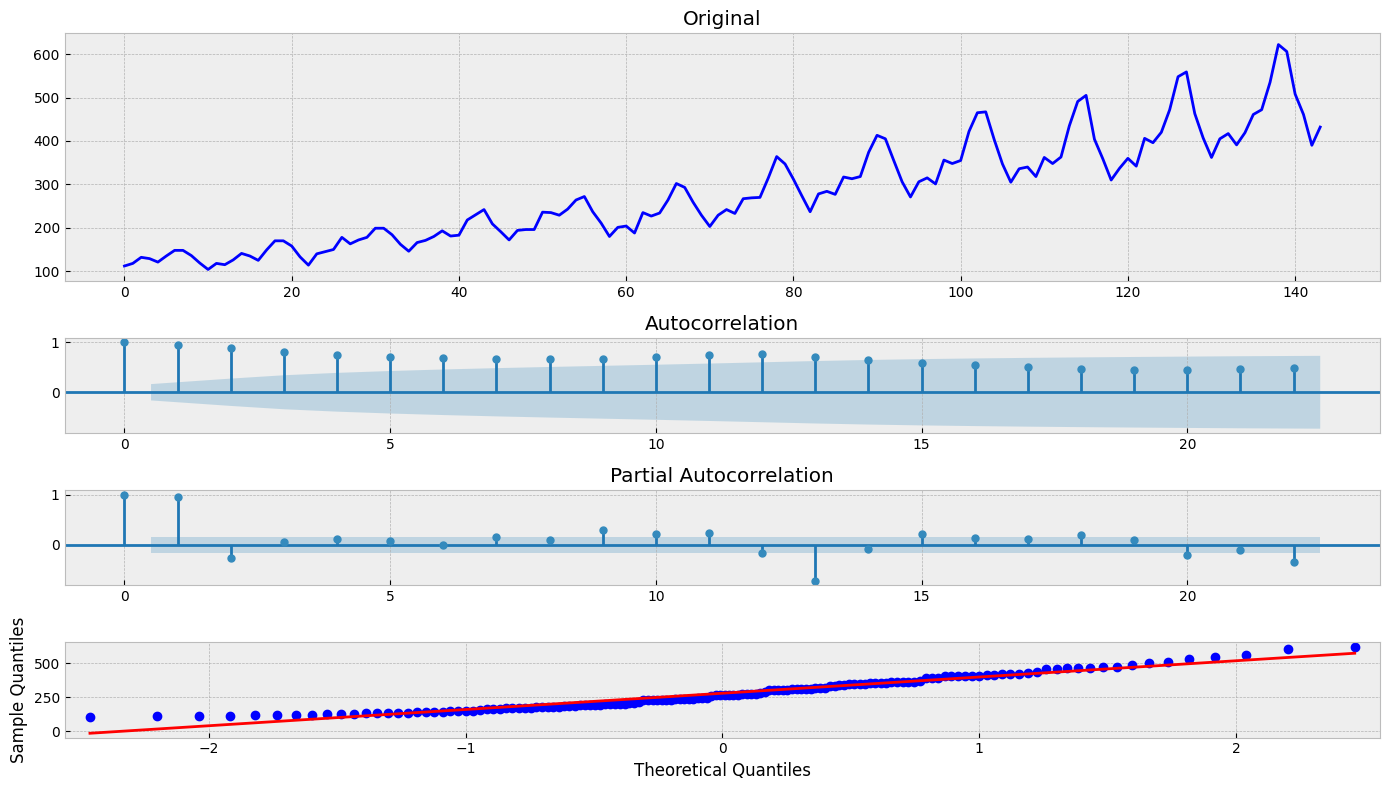

In [6]:
tsplot(series)

## ARCH

AutoRegressive Conditional Heteroscedasticit - пытаемся объяснить дисперсию в ряде через предыдущие значения (применяя к ним AR)

Пусть временной ряд представляется в таком виде:

$u_t = \epsilon_t * \sqrt{\alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2}$

Тогда условная дисперсия ряда будет равна

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2$

Получили модель ARCH(q) условной дисперсии. Требуем, чтобы все коэффициенты были больше 0 (иначе может получится отрицательная дисперсия)

Results of Dickey-Fuller Test:
Test Statistic                 -31.510128
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64


/Users/lu/opt/anaconda3/envs/old/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


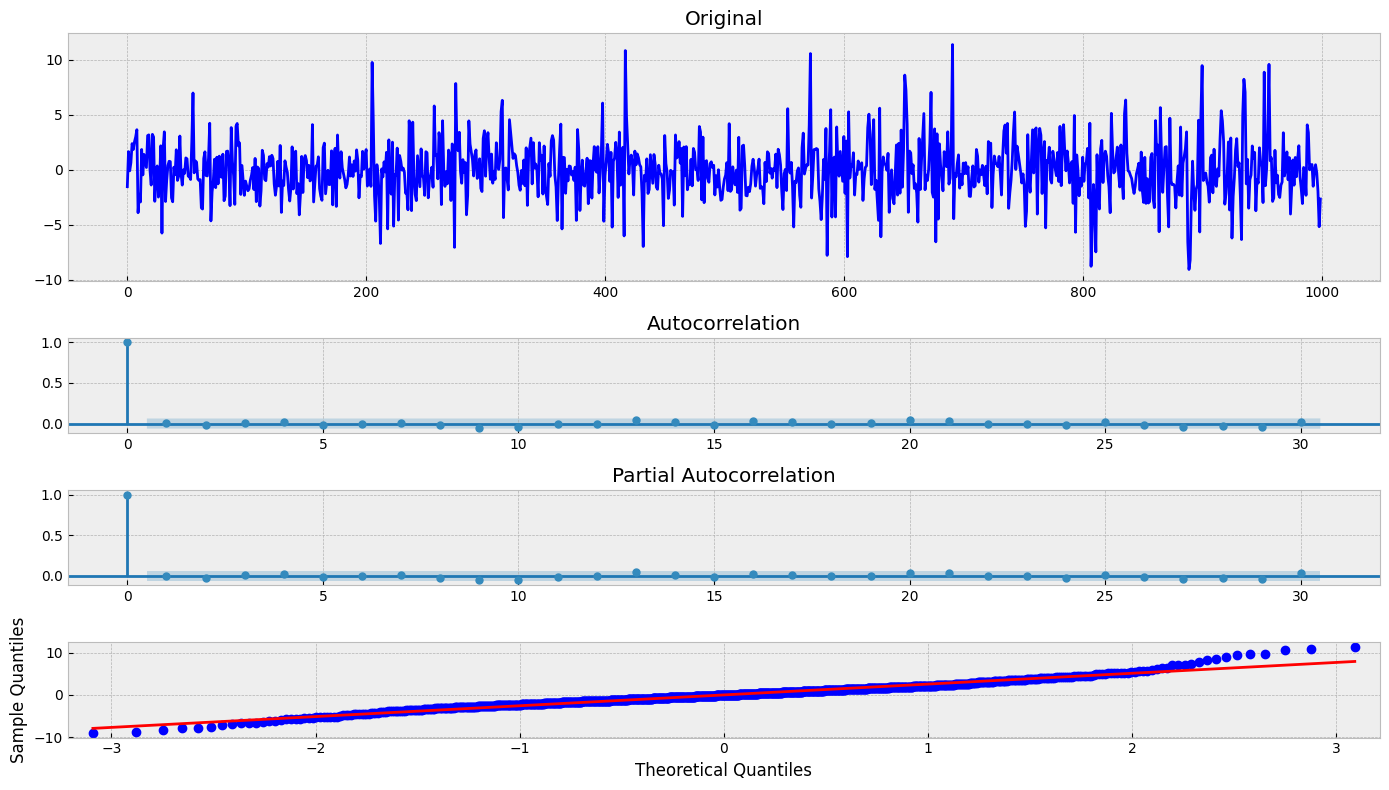

In [7]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = 5.5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30)

## GARCH

Добавляем зависимость от прошлых значений самой условной дисперсии. Получаем модель GARCH(p, q)

$\sigma_t^2 = V(u_t | u_{t-1}, ..., u_{t-q}) = \alpha_0 + \sum_{i=1}^q \alpha_i u_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2$

GARCH - по сути - модель ARMA примененная к дисперсии ряда

In [16]:
from arch import arch_model

## Практика! Реализуйте процесс GARCH, нарисуйте его график, примените к нему модель ARIMA и посмотрите на график остатков

Results of Dickey-Fuller Test:
Test Statistic                  -96.275609
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    9999.000000
Critical Value (1%)              -3.431004
Critical Value (5%)              -2.861829
Critical Value (10%)             -2.566924
dtype: float64


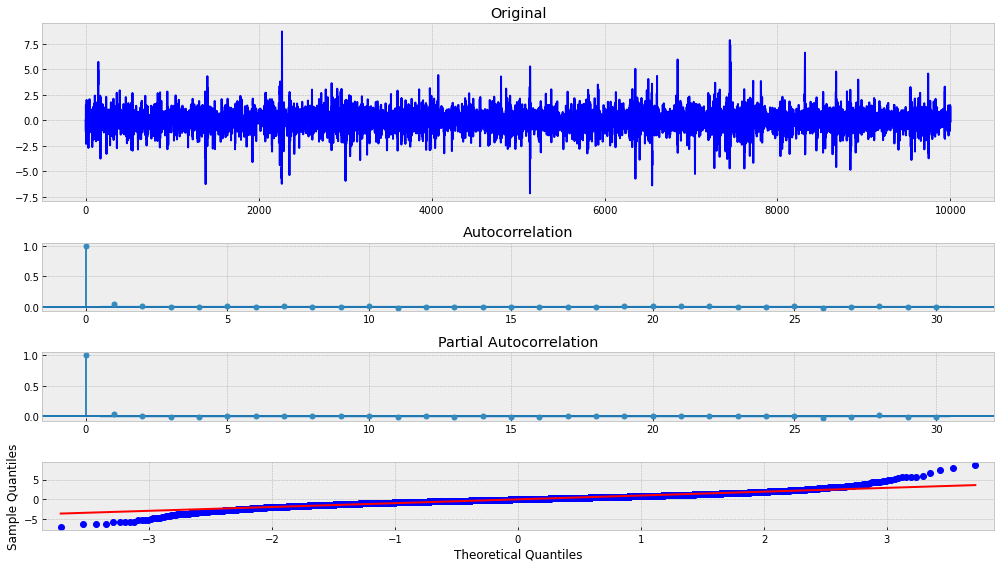

In [17]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

tsplot(eps, lags=30)

In [18]:
am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 13129.793033372622
Iteration:     10,   Func. Count:     62,   Neg. LLF: 12237.312782025878
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12237.303267318266
            Iterations: 13
            Function evaluations: 76
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Tue, Oct 25 2022   Df Residuals:                     9999
Time:       

# Продолжаем анализировать полеты

Применим ARIMA к нашему временному ряду

In [19]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

/Users/dank0r/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/dank0r/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or c

aic: 1344.38476 | order: (3, 1, 3)


/Users/dank0r/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/dank0r/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Results of Dickey-Fuller Test:
Test Statistic                  -5.229226
p-value                          0.000008
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


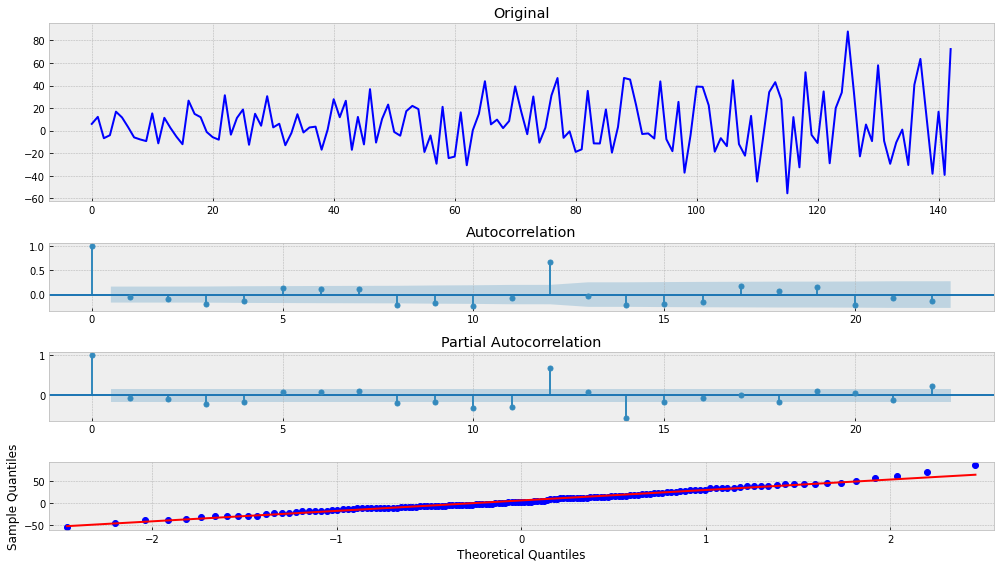

In [20]:
tsplot(mdl.resid)

Применим GARCH

In [21]:
series = series[12:] - series[:-12]
series = series[1:] - series[:-1]

In [22]:
series = series.astype(float)

In [23]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = 3
o_ = 1
q_ = 3

# Using student T distribution usually provides better fit
am = arch_model(series, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -507.387
Distribution:      Standardized Student's t   AIC:                           1024.77
Method:                  Maximum Likelihood   BIC:                           1039.15
                                              No. Observations:                  131
Date:                      Tue, Oct 25 2022   Df Residuals:                      130
Time:                              18:29:30   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

Results of Dickey-Fuller Test:
Test Statistic                -1.559562e+01
p-value                        1.856512e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


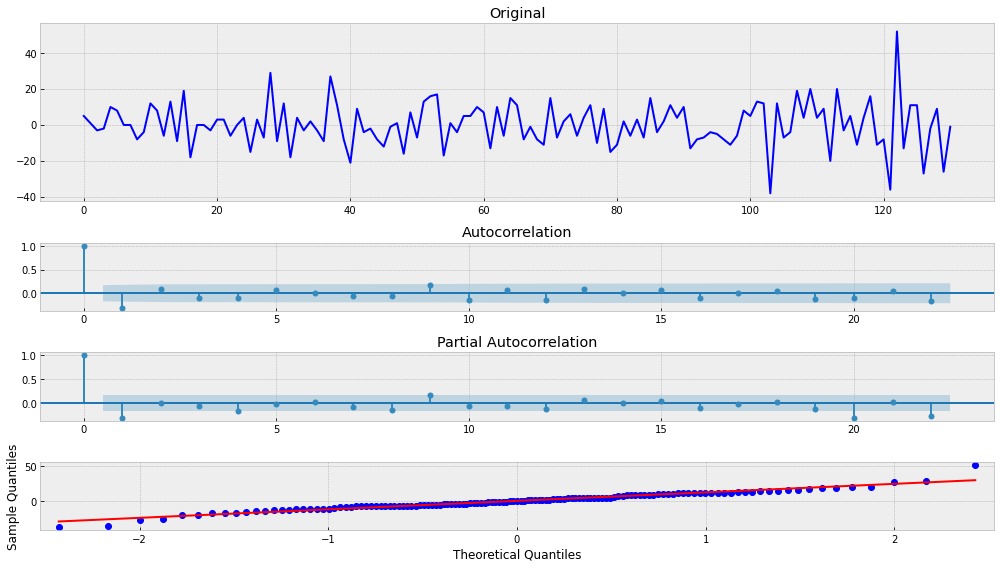

In [24]:
tsplot(res.resid)

## Проведем анализ для monthly-boston-armed-robberies-j

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


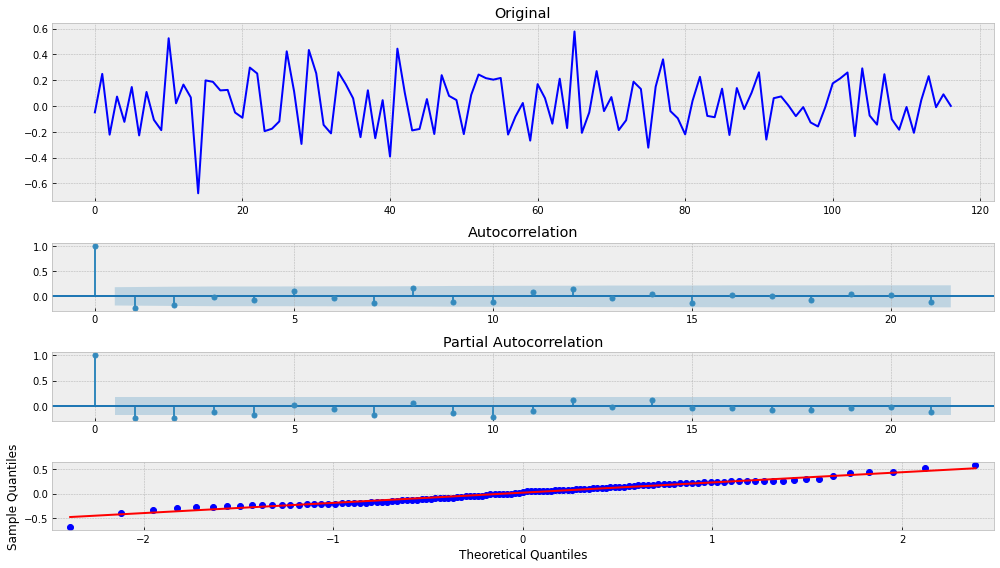

In [25]:
new_series = pd.read_csv("monthly-boston-armed-robberies-j.csv")["Count"].values.astype('float64')
new_series = boxcox(new_series, 0)
new_series = new_series[1:] - new_series[:-1]
tsplot(new_series)

In [26]:
aic, order, mdl = _get_best_model(new_series)

/Users/dank0r/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/dank0r/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to 

aic: -44.47600 | order: (2, 0, 4)


Results of Dickey-Fuller Test:
Test Statistic                -1.122900e+01
p-value                        1.928386e-20
#Lags Used                     0.000000e+00
Number of Observations Used    1.160000e+02
Critical Value (1%)           -3.488022e+00
Critical Value (5%)           -2.886797e+00
Critical Value (10%)          -2.580241e+00
dtype: float64


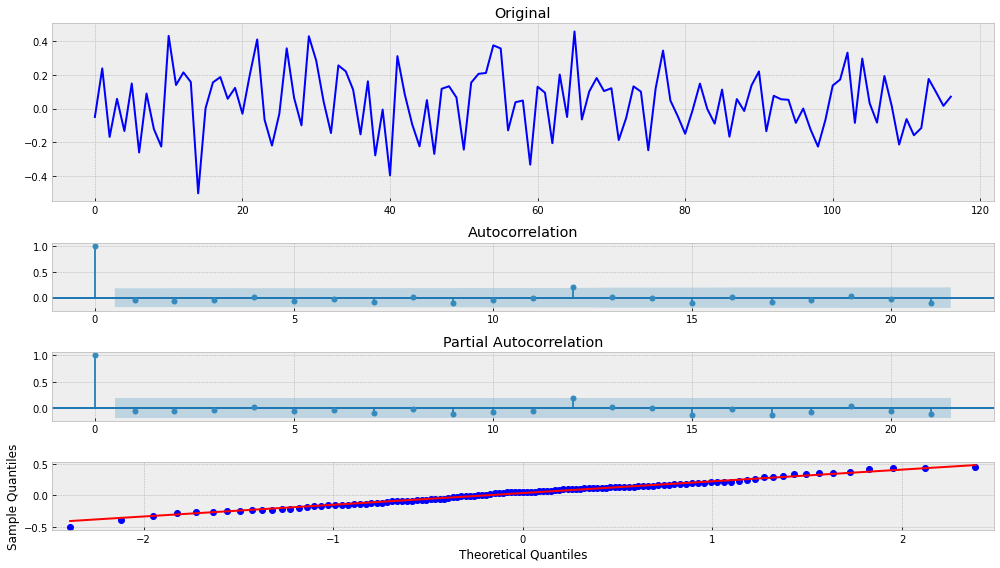

In [27]:
tsplot(mdl.resid)

In [28]:
order

(2, 0, 4)

In [29]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(new_series*100, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     54,   Neg. LLF: 519.7435540338868
Iteration:     10,   Func. Count:    104,   Neg. LLF: 519.2039231991507
Iteration:     15,   Func. Count:    154,   Neg. LLF: 518.205371187416
Iteration:     20,   Func. Count:    205,   Neg. LLF: 518.1244000518153
Optimization terminated successfully    (Exit mode 0)
            Current function value: 518.1243952097755
            Iterations: 22
            Function evaluations: 226
            Gradient evaluations: 22
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -518.124
Distribution:      Standardized Student's t   AIC:                           1054.25
Method:                  Maximum Likelihood   BIC:                           1

In [30]:
forecast = res.forecast(horizon=100)

/Users/dank0r/opt/anaconda3/lib/python3.8/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


In [31]:
new_series.shape

(117,)

In [32]:
new_series[-5:]

array([ 0.0453152 ,  0.23070979, -0.0101011 ,  0.08975718,  0.        ])

In [33]:
forecast

In [34]:
forecast.residual_variance.iloc[-1]

h.001    280.603592
h.002    279.176524
h.003    277.754037
h.004    276.314399
h.005    274.886892
            ...    
h.096    172.077787
h.097    171.194129
h.098    170.314963
h.099    169.440576
h.100    168.570696
Name: 116, Length: 100, dtype: float64

[280.60359212 279.176524   277.75403727 276.31439907 274.88689194
 273.48846569 272.09102612 270.68149319 269.28658782 267.91566365
 266.54359729 265.16398362 263.80022009 262.4559169  261.10946083
 259.75937861 258.42541887 257.10705315 255.78633904 254.46525477
 253.15989251 251.86692558 250.57197524 249.27925734 248.00141751
 246.73341163 245.46414105 244.19909878 242.94783015 241.70441317
 240.46064214 239.22255624 237.99701956 236.77785758 235.55932248
 234.3474684  233.14692233 231.95169931 230.75806733 229.57173199
 228.39551829 227.22392165 226.05480516 224.89329825 223.7408273
 222.59253848 221.4475086  220.31016957 219.18090699 218.05559587
 216.93419476 215.8203963  214.71385109 213.61117341 212.51292483
 211.42207391 210.33778835 209.25738527 208.18180347 207.11334045
 206.05088173 204.99238098 203.93897778 202.89237443 201.85132794
 200.81434583 199.78263615 198.75739289 197.73735713 196.72150112
 195.71100702 194.70664986 193.70723262 192.71210407 191.72235758
 190.738434

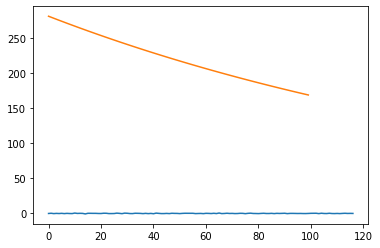

In [35]:
plt.plot(new_series)
print(forecast.residual_variance.iloc[-1].values)
plt.plot([0]*100 + forecast.residual_variance.iloc[-1].values)

Results of Dickey-Fuller Test:
Test Statistic                -7.601792e+00
p-value                        2.378602e-11
#Lags Used                     3.000000e+00
Number of Observations Used    1.130000e+02
Critical Value (1%)           -3.489590e+00
Critical Value (5%)           -2.887477e+00
Critical Value (10%)          -2.580604e+00
dtype: float64


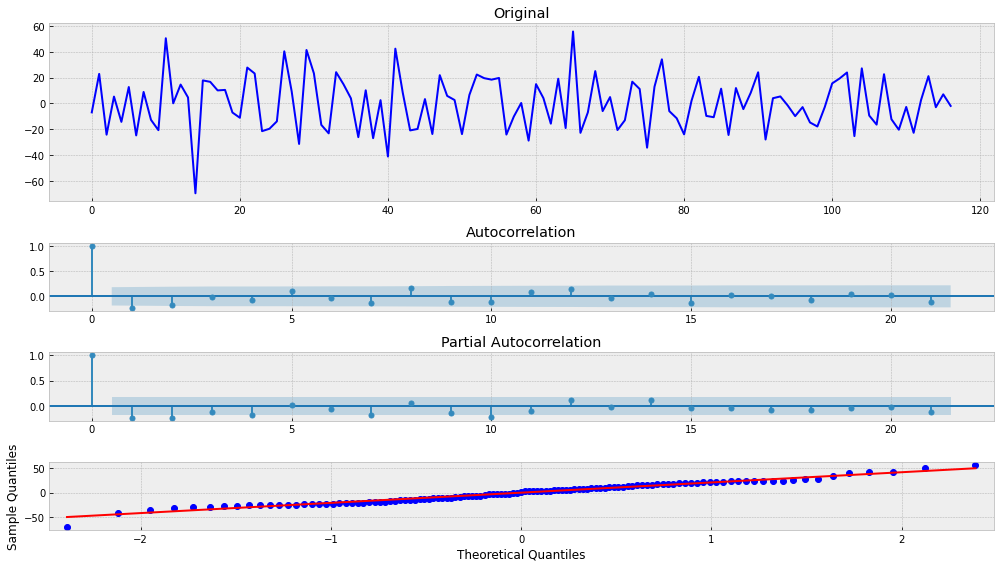

In [36]:
tsplot(res.resid)

## По простому

Такой подход является не совсем корректным (для прогнозирования свойств ВР), но он часто позволяет получать неплохие результаты в сжатые сроки

Генерируем большое количество фичей для нашего временного ряда

In [37]:
series = pd.read_csv("international-airline-passengers.csv")

In [38]:
s = pd.DataFrame(series['Count'])
s.columns = ['curr_value']

window = 10
for i in range(1, window + 1):
    s.loc[:, f'prev_val_{i}'] = s['curr_value'].shift(i)

s.dropna(inplace=True)
s.head(5)

,curr_value,prev_val_1,prev_val_2,prev_val_3,prev_val_4,prev_val_5,prev_val_6,prev_val_7,prev_val_8,prev_val_9,prev_val_10
10,104,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0,112.0
11,118,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0,118.0
12,115,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0,132.0
13,126,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0,129.0
14,141,126.0,115.0,118.0,104.0,119.0,136.0,148.0,148.0,135.0,121.0


In [39]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Month"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]
    
    return X_train, X_test, y_train, y_test

In [40]:
X_train, X_test, y_train, y_test = prepareData(series, lag_start=1, lag_end=20, test_size=0.3)

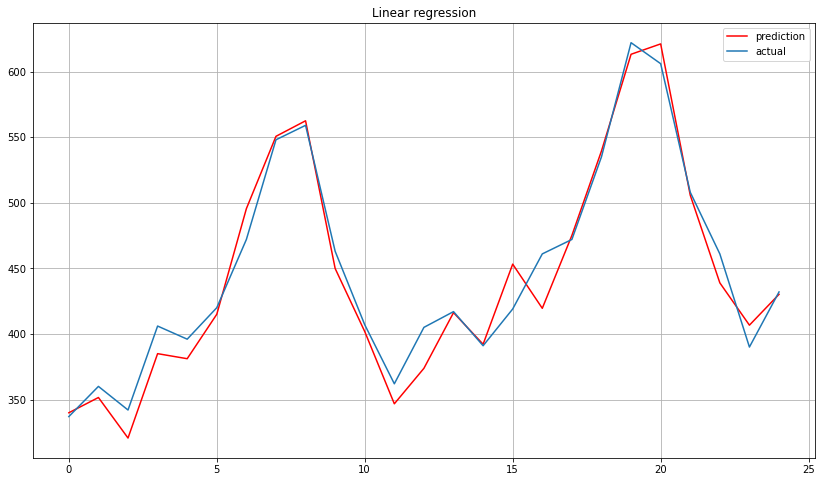

In [41]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

# Домашнее задание
- Выберите ряд и постройте его модель GARCH.
- **Не обязательное дз.** Попробуйте спрогнозировать график классическим ML

## Полезная информация
- https://people.duke.edu/~rnau/411home.htm
- https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276
- http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016